# Modeling

We've collected and cleaned our data, looked at its main characteristics, and engineered new features based off these. We are now ready to make a predictive model!

## Import Libraries and Data

In [106]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC 
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix
import itertools

# pd.set_option("display.max_rows", None, "display.max_columns", None)

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('new_feat_data.csv')
df.drop(columns = ['Unnamed: 0'],inplace=True)

In [3]:
df.head()

,PA,POP,UNDER_5,UNDER_18,65_OR_OVER,FEMALE,WHITE,BLACK,AMERICAN_INDIAN,ASIAN,...,LOG_HOUSEHOLD_INCOME,LOG_INCOME,LOG_FIRMS,LOG_POP_AREA,LOG_AREA,MAJ_FEMALE,MAJ_WHITE,SUPER_WHITE,HOUSE_RATIO,POP_LARGE
0,1,85108.0,0.069,0.254,0.156,0.528,0.727,0.174,0,0.049,...,11.339072,10.691922,8.984944,7.456223,3.853546,1,1,0,6.372872,1
1,0,68247.0,0.065,0.236,0.172,0.528,0.622,0.340,0,0.011,...,10.729438,10.227309,8.797851,6.596600,4.493121,1,1,0,5.309606,1
2,1,101113.0,0.059,0.188,0.117,0.524,0.511,0.441,0,0.024,...,10.694668,10.141086,8.824972,7.314486,4.098171,1,1,0,6.856174,1
3,1,65738.0,0.051,0.183,0.075,0.506,0.729,0.170,0,0.085,...,10.706699,10.228863,8.446556,6.823613,4.061649,1,1,0,9.064317,1
4,0,50440.0,0.049,0.244,0.107,0.502,0.741,0.150,0,0.055,...,11.402240,10.721040,8.163656,7.279939,3.387436,1,1,0,5.408508,1


## Feature Selection I

We'll first need to select which features we want to include in our model. 

### Hypothesis Tests for New Features

Let's start by looking at our engineered features:
* `MAJ_FEMALE`
* `MAJ_WHITE`
* `SUPER_WHITE`
* `HOUSE_RATIO`
* `POP_LARGE`

We'll run Z tests on these features to check the following, with the groups meaning the features we made:
_Null Hypothesis: Proportion of different classes among these groups is the same._
_Alternative Hypothesis: Proportion of different classes among these groups is different._

We won't run a hypothesis test on our `HOUSE_RATIO` column because it is the only non-class variable.

If we can reject the null hypothesis, then we know that feature may be useful for our model. Otherwise, we won't use it. We will use a p-value of 0.05.

In [4]:
values = df.groupby(['MAJ_FEMALE','PA']).PA.count()
values

MAJ_FEMALE  PA
0           0      331
            1      301
1           0     1164
            1     1223
Name: PA, dtype: int64

In [5]:
lengths = df.groupby('MAJ_FEMALE')['PA'].count()
lengths

MAJ_FEMALE
0     632
1    2387
Name: PA, dtype: int64

In [6]:
#we'll set our proportions equal to proportion of conservative
pro_1 = values[0][0]/lengths[0] 
pro_2 = values[1][0]/lengths[1] 
pro_overall = (values[0][0]+values[1][0])/(lengths[0]+lengths[1])

print(f'Proportion of conservative cities without a female majority to all cities without a female majority: \n{pro_1}\n')
print(f'Proportion of conservative cities with a female majority to all cities with a female majority: \n{pro_2}\n')
print(f'Proportion of all conservative cities to all cities: \n{pro_overall}\n')

Proportion of conservative cities without a female majority to all cities without a female majority: 
0.5237341772151899

Proportion of conservative cities with a female majority to all cities with a female majority: 
0.4876413908671973

Proportion of all conservative cities to all cities: 
0.4951970851275257



In [7]:
z_score = (pro_1 - pro_2)/np.sqrt((pro_overall*(1-pro_overall))*(1/lengths[0]+1/lengths[1]))
z_score

1.613703110134233

In [8]:
stats.norm.cdf(z_score)

0.9467040804852496

Since this is above our p-value, we cannot reject the null for `MAJ_FEMALE` and as such will remove it from our features.

In [9]:
df.drop(columns = ['MAJ_FEMALE'],inplace=True)

In [10]:
values = df.groupby(['MAJ_WHITE','PA']).PA.count()
lengths = df.groupby('MAJ_WHITE')['PA'].count()

#we'll set our proportions equal to proportion of conservative
pro_1 = values[0][0]/lengths[0] 
pro_2 = values[1][0]/lengths[1] 
pro_overall = (values[0][0]+values[1][0])/(lengths[0]+lengths[1])

print(f'Proportion of conservative cities without a white majority to all cities without a white majority: \n{pro_1}\n')
print(f'Proportion of conservative cities with a white majority to all cities with a white majority: \n{pro_2}\n')
print(f'Proportion of all conservative cities to all cities: \n{pro_overall}\n')

z_score = (pro_1 - pro_2)/np.sqrt((pro_overall*(1-pro_overall))*(1/lengths[0]+1/lengths[1]))

stats.norm.cdf(z_score)

Proportion of conservative cities without a white majority to all cities without a white majority: 
0.13442622950819672

Proportion of conservative cities with a white majority to all cities with a white majority: 
0.5357406042741342

Proportion of all conservative cities to all cities: 
0.4951970851275257



1.3051275880671363e-40

Since this is much lower than our p-value, we reject the null for `MAJ_WHITE`. It looks like this will be a pretty important indicator for our model.

In [11]:
values = df.groupby(['SUPER_WHITE','PA']).PA.count()
lengths = df.groupby('SUPER_WHITE')['PA'].count()

#we'll set our proportions equal to proportion of conservative
pro_1 = values[0][0]/lengths[0] 
pro_2 = values[1][0]/lengths[1] 
pro_overall = (values[0][0]+values[1][0])/(lengths[0]+lengths[1])

print(f'Proportion of conservative cities without a super white majority to all cities without a super white majority: \n{pro_1}\n')
print(f'Proportion of conservative cities with a super white majority to all cities with a super white majority: \n{pro_2}\n')
print(f'Proportion of all conservative cities to all cities: \n{pro_overall}\n')

z_score = (pro_1 - pro_2)/np.sqrt((pro_overall*(1-pro_overall))*(1/lengths[0]+1/lengths[1]))

stats.norm.cdf(z_score)

Proportion of conservative cities without a super white majority to all cities without a super white majority: 
0.43652743652743653

Proportion of conservative cities with a super white majority to all cities with a super white majority: 
0.7435008665511266

Proportion of all conservative cities to all cities: 
0.4951970851275257



1.8677285264742334e-40

In [12]:
z_score

-13.264167574716655

This value is also much lower than our p-value, so we reject the null for `SUPER_WHITE`. As expected, another feature with our `WHITE` column seems to be an important indicator.

In [13]:
values = df.groupby(['POP_LARGE','PA']).PA.count()
lengths = df.groupby('POP_LARGE')['PA'].count()

#we'll set our proportions equal to proportion of conservative
pro_1 = values[0][0]/lengths[0] 
pro_2 = values[1][0]/lengths[1] 
pro_overall = (values[0][0]+values[1][0])/(lengths[0]+lengths[1])
print(f'Proportion of conservative cities without a super white majority to all cities without a super white majority: \n{pro_1}\n')
print(f'Proportion of conservative cities with a super white majority to all cities with a super white majority: \n{pro_2}\n')
print(f'Proportion of all conservative cities to all cities: \n{pro_overall}\n')

z_score = (pro_1 - pro_2)/np.sqrt((pro_overall*(1-pro_overall))*(1/lengths[0]+1/lengths[1]))

stats.norm.cdf(z_score)

Proportion of conservative cities without a super white majority to all cities without a super white majority: 
0.5553335996803835

Proportion of conservative cities with a super white majority to all cities with a super white majority: 
0.20348837209302326

Proportion of all conservative cities to all cities: 
0.4951970851275257



1.0

This z_score is large, so we reject the null for `POP_LARGE`.

### Log Columns

Now that we've made our insights from these values, we'll remove the original columns and keep their logged counterparts, as mentioned in our Data Cleaning section.

In [14]:
logged_columns = [x for x in list(df.columns) if "LOG_" in x]
dropping_columns = [x.replace("LOG_","") for x in logged_columns]
df.drop(columns = dropping_columns,inplace=True)

### Multicollinearity

Let's check our features for multicollinearity. We'll look for anything which has a correlation value of over 0.9.

In [15]:
abs(df.corr()) > 0.85

,PA,UNDER_5,UNDER_18,65_OR_OVER,FEMALE,WHITE,BLACK,AMERICAN_INDIAN,ASIAN,PACIFIC_ISLANDER,...,LOG_TRAVEL_TIME,LOG_HOUSEHOLD_INCOME,LOG_INCOME,LOG_FIRMS,LOG_POP_AREA,LOG_AREA,MAJ_WHITE,SUPER_WHITE,HOUSE_RATIO,POP_LARGE
PA,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
UNDER_5,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
UNDER_18,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
65_OR_OVER,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
FEMALE,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
WHITE,False,False,False,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
BLACK,False,False,False,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
AMERICAN_INDIAN,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
ASIAN,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
PACIFIC_ISLANDER,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


Highly correlated features:
* `WHITE` and `BLACK`
* `HISPANIC` and `OTHER_HOME_LANG`
* `FOREIGN` and `OTHER_HOME_LANG`
* `COMPUTER` and `INTERNET`
* `LABOR` and `FEM_LABOR`
* `POVERTY` and `LOG_HOUSEHOLD_INCOME`
* `LOG_HOUSEHOLD_INCOME` and `LOG_INCOME`
* `LOG_POP`, `LOG_HOUSEHOLDS`, and `LOG_FIRMS`

We'll need to remove one from each of these. 

Firstly, we know we cannot remove `WHITE` or `BLACK` because they were both used to make other features. As the collinearity is only a bit higher than 0.85, we'll keep both in, but note that they are highly correlated. Next, we see `OTHER_HOME_LANG` and `LOG_HOUSEHOLD_INCOME` are both correlated to two other features, so we will remove them. We can't remove `LOG_POP` because it is used to make other features, so we'll remove `LOG_HOUSEHOLDS` and `LOG_FIRMS` from this line.

Let's look at just the correlation values between the rest.

In [16]:
corr_df = df[['COMPUTER','INTERNET', 'PA']]
corr_df.corr()

,COMPUTER,INTERNET,PA
COMPUTER,1.000000,0.907505,0.104098
INTERNET,0.907505,1.000000,0.101747
PA,0.104098,0.101747,1.000000


In [17]:
corr_df = df[['LABOR','FEM_LABOR', 'PA']]
corr_df.corr()

,LABOR,FEM_LABOR,PA
LABOR,1.000000,0.878337,0.120627
FEM_LABOR,0.878337,1.000000,0.172227
PA,0.120627,0.172227,1.000000


In [18]:
df.drop(columns = ['OTHER_HOME_LANG','INTERNET','LABOR','LOG_HOUSEHOLD_INCOME','LOG_FIRMS','LOG_HOUSEHOLDS'],inplace=True)

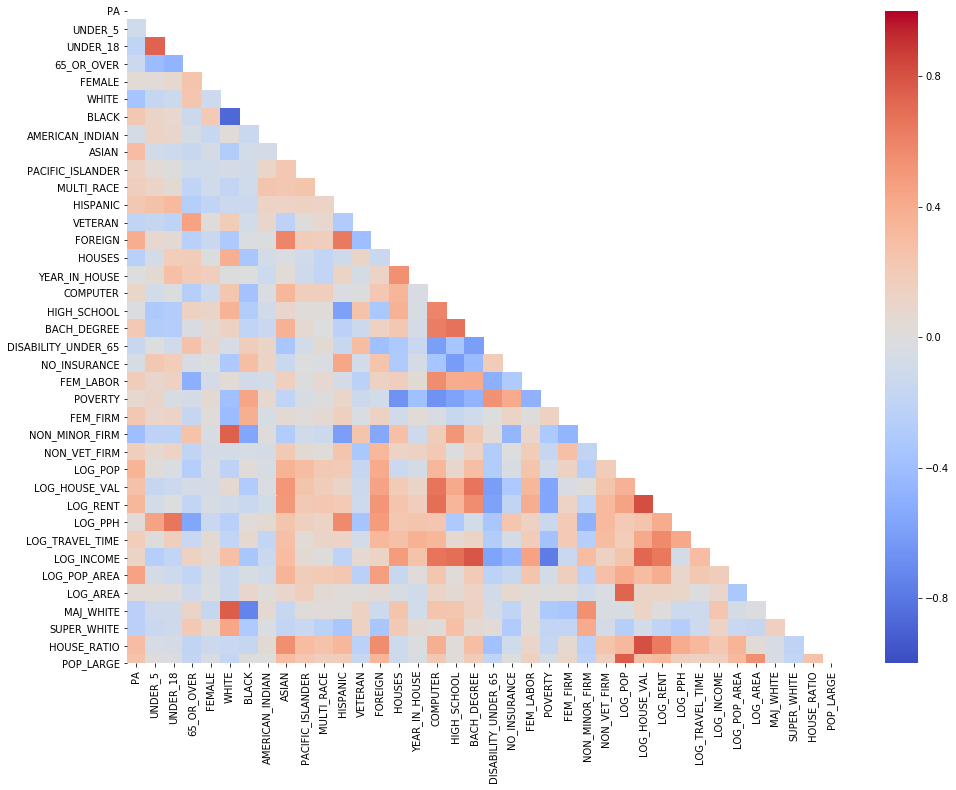

In [19]:
f, ax = plt.subplots(figsize=(16, 12))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask = matrix)

## Initial Models

### Define our X and y variables

In [20]:
X = df.drop(columns = 'PA')
y = df['PA']
print(X.shape)
print(y.shape)

(3019, 37)
(3019,)


### Modeling Function

In [21]:
def classification_models(X,y,models,test_size = .2,random_state = 13,params=None,grid=False,param_grid=None,cv=5):
    '''Creates models from given input and returns a table of evaluation metrics for each model.'''
    #create scaler
    scaler = MinMaxScaler()
    scaler.fit(X)
    #dictionary of models
    model_dict = {'logistic': LogisticRegression,'knn': KNeighborsClassifier,
                 'tree': DecisionTreeClassifier,'rf': RandomForestClassifier,
                 'xgb': xgb.XGBClassifier, 'AdaBoost': AdaBoostClassifier,
                 'GrdBoost': GradientBoostingClassifier, 'svc': SVC,
                 'Bayes': GaussianNB}
    #scale data
    X_transformed = scaler.transform(X)
    #split data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X_transformed, y,test_size = test_size, random_state=random_state)
    #create evaluation metrics table
    summary_df = pd.DataFrame(columns=['Model','Accuracy', 'Recall', 'Precision',  'F1'])
    #variable to keep track of which parameter dictionary we are on 
    i = 0
    #if no params given and gridsearch is false, create base models
    if (params==None) & (grid == False):
        for model in models:
            for key, value in model_dict.items(): 
                if model == key: 
                    model_use = value()
                    model_use.fit(X_train,y_train)
                    predictions = model_use.predict(X_test)
                    summary_df = summary_df.append({'Model': model,
                       'Accuracy': metrics.accuracy_score(y_test, predictions),
                       'Recall': metrics.recall_score(y_test, predictions),
                       'Precision': metrics.precision_score(y_test, predictions), 
                       'F1': metrics.f1_score(y_test, predictions)},ignore_index=True)
    #if gridsearch is true, run a gridsearch and use best parameters to create models
    elif grid == True:
        for model in models:
            for key, value in model_dict.items(): 
                if model == key: 
                    model_use = GridSearchCV(estimator = value(),param_grid = param_grid[i],cv = cv)
                    model_use.fit(X_train,y_train)
                    model_grid = value(**model_use.best_params_)
                    model_grid.fit(X_train,y_train)
                    y_pred = model_grid.predict(X_test)
                    i = i+1
                    summary_df = summary_df.append({'Model': model,
                   'Accuracy': metrics.accuracy_score(y_test, y_pred),
                   'Recall': metrics.recall_score(y_test, y_pred),
                   'Precision': metrics.precision_score(y_test, y_pred), 
                   'F1': metrics.f1_score(y_test, y_pred)},ignore_index=True)
                    print(f"{model}'s best parameters are {model_use.best_params_}")
    #if previous conditions are false, then we have been given parameters and gridsearch is false
    #we create models with given parameters
    else:
        for model in models:
            for key, value in model_dict.items(): 
                if model == key: 
                    model_use = value(**params[i])
                    model_use.fit(X_train,y_train)
                    y_pred = model_use.predict(X_test)
                    i = i+1
                    summary_df = summary_df.append({'Model': model,
                   'Accuracy': metrics.accuracy_score(y_test, y_pred),
                   'Recall': metrics.recall_score(y_test, y_pred),
                   'Precision': metrics.precision_score(y_test, y_pred), 
                   'F1': metrics.f1_score(y_test, y_pred)},ignore_index=True)
                    print("params")
    return summary_df

### Create Initial Models for X and y

We want to run all types of models and select whichever works best with our data.

We'll check our base model metrics first.

In [22]:
models = ['logistic','knn','tree','rf','AdaBoost','xgb','GrdBoost','svc','Bayes']
classification_models(X,y,models)

,Model,Accuracy,Recall,Precision,F1
0,logistic,0.817881,0.791277,0.855219,0.822006
1,knn,0.769868,0.719626,0.825000,0.768719
2,tree,0.745033,0.750779,0.765079,0.757862
3,rf,0.812914,0.753894,0.876812,0.810720
4,AdaBoost,0.829470,0.800623,0.868243,0.833063
5,xgb,0.821192,0.785047,0.865979,0.823529
6,GrdBoost,0.824503,0.794393,0.864407,0.827922
7,svc,0.806291,0.725857,0.889313,0.799314
8,Bayes,0.740066,0.635514,0.836066,0.722124


Next, let's create some gridsearch models.

In [23]:
grid_models = ['logistic','knn','tree','rf','AdaBoost','GrdBoost','svc']
param_grid = [{'penalty': ['l1', 'l2'], 
               'C': np.logspace(-4, 4, 10)}, #logistic
              {'n_neighbors': [1,3,5],
               'weights':['uniform','distance'],
               'metric': ['euclidean','manhattan']}, #knn
              {'criterion': ['gini', 'entropy'],
               'max_depth' : [2,5,50],
               'min_samples_leaf':[1,2,8],
               'min_samples_split':[2,4]}, #tree
              {'n_estimators': [10,50,200],
               'max_features': ['auto', 'sqrt','log2'],
               'max_depth': [2,5],
               'min_samples_split' : [2,4],
               'min_samples_leaf' : [1,4],
               'bootstrap': [True, False]}, #rf
             {'n_estimators': [10,50,200],
              'learning_rate': np.linspace(0.01,1,10)}, #adaboost
             {'learning_rate': np.linspace(0.01,1,10),
              'n_estimators': [10,50,100],
              'max_features': ['auto', 'sqrt','log2'],
              'max_depth': [2,4,8],'min_samples_split' : [2,4]}, #grdboost
             {'C' : np.linspace(0.01,10,6),
              'gamma' : np.linspace(0.01,1,6),
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}] #svc

In [24]:
classification_models(X,y,grid_models,param_grid=param_grid,grid=True)

logistic's best parameters are {'C': 10000.0, 'penalty': 'l2'}
knn's best parameters are {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
tree's best parameters are {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
rf's best parameters are {'bootstrap': False, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 200}
AdaBoost's best parameters are {'learning_rate': 0.23, 'n_estimators': 200}
GrdBoost's best parameters are {'learning_rate': 0.12, 'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 4, 'n_estimators': 100}
svc's best parameters are {'C': 2.008, 'gamma': 0.802, 'kernel': 'rbf'}


,Model,Accuracy,Recall,Precision,F1
0,logistic,0.824503,0.809969,0.852459,0.830671
1,knn,0.769868,0.719626,0.825000,0.768719
2,tree,0.768212,0.676012,0.857708,0.756098
3,rf,0.791391,0.738318,0.849462,0.790000
4,AdaBoost,0.826159,0.794393,0.867347,0.829268
5,GrdBoost,0.827815,0.800623,0.865320,0.831715
6,svc,0.817881,0.791277,0.855219,0.822006


## Feature Selection II

In the context of our data, there is no need to prioritize precision or recall since the cost for false negatives/positives is the same. Due to this, we focus on accuracy and F1 score as our primary evaluation metrics.

From our initial models we decided that Gradient Boosting Classifier, Support Vector Classification, and Logistic Regression have the best accuracy and F1 score for both base models and models with gridsearched best parameters. We'll focus on these for our future models.

We'll get coefficients for the logistic model to see if we have any features we want to drop which may improve our models.

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .2, random_state=13)
logreg = LogisticRegression(C=10000.0)
logreg.fit(X_train, y_train)

LogisticRegression(C=10000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [63]:
summary_df = pd.DataFrame(columns=['Model','Accuracy', 'Recall', 'Precision',  'F1'])
predictions = logreg.predict(X_test)
summary_df = summary_df.append({'Model': 'Logistic',
                    'Accuracy': metrics.accuracy_score(y_test, predictions),
                   'Recall': metrics.recall_score(y_test, predictions),
                   'Precision': metrics.precision_score(y_test, predictions), 
                   'F1': metrics.f1_score(y_test, predictions)},ignore_index=True)
summary_df

,Model,Accuracy,Recall,Precision,F1
0,Logistic,0.82947,0.799342,0.852632,0.825127


In [65]:
weights = dict(zip(list(X_train.columns), list(logreg.coef_[0])))
{k: v for k, v in sorted(weights.items(), key=lambda item: abs(item[1]),reverse=True)}

{'UNDER_18': -25.701194670179213,
 'UNDER_5': 20.31086800509801,
 'NO_INSURANCE': -13.739716729057434,
 'MULTI_RACE': 12.52399316188831,
 'FOREIGN': 11.814182297270424,
 'FEM_LABOR': 10.75623779612032,
 'HIGH_SCHOOL': 9.184324129207633,
 'POVERTY': 8.758071445816393,
 'DISABILITY_UNDER_65': 7.971023516188074,
 'FEMALE': 7.903720498580588,
 'YEAR_IN_HOUSE': 7.770894247363787,
 'VETERAN': -6.148958574054654,
 'NON_MINOR_FIRM': -6.056527303776806,
 'LOG_POP_AREA': 5.5971727256617925,
 'LOG_AREA': 4.890018137065851,
 'HISPANIC': 4.8084292965316235,
 'LOG_POP': -4.691902829024709,
 'ASIAN': -4.232307019327911,
 'COMPUTER': -3.7226234146950907,
 'HOUSES': -3.6206069655126383,
 'LOG_INCOME': 3.479899137340986,
 'LOG_PPH': -3.234077176965769,
 'BACH_DEGREE': 2.9211539137148117,
 'LOG_HOUSE_VAL': -2.7853877224249715,
 'LOG_RENT': 2.2737997660555416,
 'FEM_FIRM': 1.8588773057404555,
 'LOG_TRAVEL_TIME': 1.3939694129767208,
 'MAJ_WHITE': -1.3608663345325327,
 'WHITE': -1.3281942238545899,
 'NON_VE

Based on these values, we're going to drop:
* `POP_LARGE`
* `AMERICAN_INDIAN`
* `PACIFIC_ISLANDER`
* `SUPER_WHITE`

In [74]:
dropping_cols = ['POP_LARGE','AMERICAN_INDIAN','PACIFIC_ISLANDER','SUPER_WHITE']
X_improv = df.drop(columns = dropping_cols)
X_improv.drop(columns = 'PA', inplace=True)

Let's see if this improves our models at all.

In [75]:
grid_models = ['logistic','GrdBoost','svc']
param_grid = [{'penalty': ['l1', 'l2'], 
               'C': np.logspace(-4, 4, 10)}, #logistic
             {'learning_rate': np.linspace(0.01,1,10),
              'n_estimators': [10,50,100],
              'max_features': ['auto', 'sqrt','log2'],
              'max_depth': [2,4,8],'min_samples_split' : [2,4]}, #grdboost
             {'C' : np.linspace(0.01,10,6),
              'gamma' : np.linspace(0.01,1,6),
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}] #svc

classification_models(X_improv,y,grid_models,param_grid=param_grid,grid=True)

logistic's best parameters are {'C': 21.54434690031882, 'penalty': 'l2'}
GrdBoost's best parameters are {'learning_rate': 0.12, 'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 4, 'n_estimators': 100}
svc's best parameters are {'C': 4.006, 'gamma': 0.20800000000000002, 'kernel': 'poly'}


,Model,Accuracy,Recall,Precision,F1
0,logistic,0.819536,0.803738,0.848684,0.825600
1,GrdBoost,0.842715,0.806854,0.886986,0.845024
2,svc,0.834437,0.800623,0.877133,0.837134


Our Logistic Regression model's accuracy decreased very slightly, but every other metric improved, and every metric for our Gradient Boosting Classifier and Support Vector Classification models went up!

Lastly, let's try creating some polynomial features and seeing how these affect our models.

In [80]:
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X)

In [81]:
classification_models(X_poly,y,grid_models,param_grid=param_grid,grid=True)

logistic's best parameters are {'C': 2.782559402207126, 'penalty': 'l2'}
GrdBoost's best parameters are {'learning_rate': 0.12, 'max_depth': 8, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100}
svc's best parameters are {'C': 2.008, 'gamma': 0.01, 'kernel': 'linear'}


,Model,Accuracy,Recall,Precision,F1
0,logistic,0.832781,0.816199,0.861842,0.838400
1,GrdBoost,0.826159,0.806854,0.857616,0.831461
2,svc,0.826159,0.800623,0.862416,0.830372


The only model with improved metrics is Logistic Regression.

## Final Model

Our best model is Gradient Boosting Classifier on `X_improv` features!

In [100]:
scaler = MinMaxScaler()
scaler.fit(X_improv)
X_transformed = scaler.transform(X_improv)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y,test_size = .2, random_state=13)
winning_model = GradientBoostingClassifier(learning_rate= 0.12, max_depth= 8, max_features= 'log2', min_samples_split= 4, n_estimators= 100, random_state=13)

winning_model.fit(X_train, y_train)
    
predictions = winning_model.predict(X_test)
    
summary_df = pd.DataFrame(columns=['Model','Accuracy', 'Recall', 'Precision',  'F1'])
summary_df = summary_df.append({'Model': 'Gradient Boosting Classifier',
                    'Accuracy': metrics.accuracy_score(y_test, predictions),
                   'Recall': metrics.recall_score(y_test, predictions),
                   'Precision': metrics.precision_score(y_test, predictions), 
                   'F1': metrics.f1_score(y_test, predictions)},ignore_index=True)
summary_df

,Model,Accuracy,Recall,Precision,F1
0,Gradient Boosting Classifier,0.832781,0.813084,0.864238,0.837881


In [117]:
weights = dict(zip(list(X_improv.columns), list(winning_model.feature_importances_)))
{k: v for k, v in sorted(weights.items(), key=lambda item: item[1],reverse=True)}

{'LOG_POP_AREA': 0.18591589711773124,
 'FOREIGN': 0.07800289247442284,
 'WHITE': 0.06870385165126801,
 'NON_MINOR_FIRM': 0.060033253859204515,
 'HOUSE_RATIO': 0.04631084277953032,
 'LOG_POP': 0.036623360268594585,
 'UNDER_18': 0.03169903155100658,
 'LOG_HOUSE_VAL': 0.02816696514121472,
 'LOG_PPH': 0.028093143055423552,
 'LOG_RENT': 0.027478941535925203,
 'MAJ_WHITE': 0.02638657458815332,
 'NO_INSURANCE': 0.02623228258804391,
 'BLACK': 0.025980925761638525,
 'BACH_DEGREE': 0.022689971065620113,
 'HISPANIC': 0.02240475334556729,
 'FEM_LABOR': 0.022207729614395284,
 'LOG_AREA': 0.021626100389852965,
 'HOUSES': 0.02023661274446337,
 'LOG_TRAVEL_TIME': 0.020045473155523925,
 'ASIAN': 0.01924984708985814,
 'HIGH_SCHOOL': 0.019195021215812718,
 'UNDER_5': 0.019091944100173352,
 'VETERAN': 0.01678878604702882,
 'FEM_FIRM': 0.015210793914223236,
 'COMPUTER': 0.015026201419691503,
 'NON_VET_FIRM': 0.013664492125599352,
 'POVERTY': 0.01359777190627486,
 'YEAR_IN_HOUSE': 0.013480969113873024,
 'FE

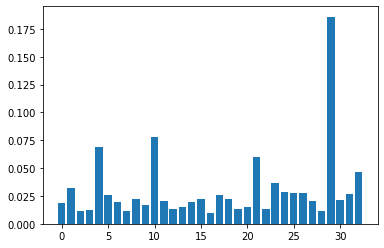

In [119]:
plt.bar(range(len(winning_model.feature_importances_)), winning_model.feature_importances_)
plt.show()

Let's look further into the values we are predicting incorrectly.

In [103]:
cm = confusion_matrix(y_test,predictions)
classes = ['Conservative', 'Liberal']

In [114]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[242  41]
 [ 60 261]]


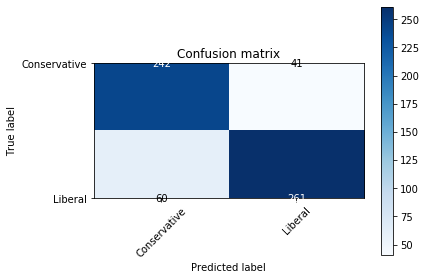

In [115]:
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues)